<a href="https://colab.research.google.com/github/natthanich/EfficientNet_Classification_DeepTooth/blob/main/224_04_Func_Eff_Classification_Train_250_Unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [ ]:
import pandas as pd
import shutil

In [ ]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import pandas as pd
#import tensorflow_addons as tfa
import glob, warnings
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import callbacks as callbacks_
from keras import models
import datetime

#กำหนดค่าพารามิเตอร์


In [ ]:
batch_size = 16
width = 224 # จตุรัส โมเตลจะเรียนรู้ภาพได้ดีที่สุด
height = 224
epochs = 250 # รอบในการเทรน
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

# Load Model

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func_224/1_3_2e-5_250_Unreeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
#load model
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func_224/1_3_2e-5_250_Unreeze.h5')
height = width = model.input_shape[1]

In [ ]:
model.summary()

Model: "EffNet_Classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_no

# Data Preparation

In [ ]:
df = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/table_cut_images/table_train_10Fold_forGender.csv')
df

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...,...
4184,4184,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J375.jpg,3,1
4185,4185,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J437.jpg,5,1
4186,4186,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J480.jpg,5,1
4187,4187,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J491.jpg,6,1


In [ ]:
df = df.iloc[:,1:]

In [ ]:
val = df[df['Fold']==4]
val

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
12,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V16.jpg,4,0
35,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV41.jpg,4,0
36,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V42.jpg,4,0
47,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV54.jpg,4,0
...,...,...,...,...,...,...,...,...
4139,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J442.jpg,4,1
4140,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipJ442.jpg,4,1
4144,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipJ467.jpg,4,1
4150,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipJ472.jpg,4,1


In [ ]:
train = df[~df['Fold'].isin(val['Fold'])]
train

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
5,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV3.jpg,9,0
...,...,...,...,...,...,...,...,...
4184,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J375.jpg,3,1
4185,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J437.jpg,5,1
4186,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J480.jpg,5,1
4187,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J491.jpg,6,1


In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal"
os.chdir(DATA_PATH)
#train_dir = os.path.join(DATA_PATH, 'train')
#print(train_dir)
#validation_dir = os.path.join(DATA_PATH, 'validation')
#print(validation_dir)


#Train

In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Gender_Class',
        class_mode = 'raw',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Gender_Class',
        class_mode = 'raw',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

Found 3796 validated image filenames.
Found 393 validated image filenames.


In [ ]:
model.compile(loss='binary_crossentropy',
          optimizer=Adam(learning_rate=2e-5),
          metrics=['accuracy'])
logdir = os.path.join("/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/logs_Eff_Class_Func_224/logs4-1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= len(train) //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= len(val) //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      callbacks=[tensorboard_callback])

<ipython-input-18-e04bea193954>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
237/237 [==============================] - 634s 2s/step - loss: 0.0805 - accuracy: 0.9725 - val_loss: 0.0165 - val_accuracy: 0.9948
Epoch 2/250
237/237 [==============================] - 30s 123ms/step - loss: 0.0758 - accuracy: 0.9733 - val_loss: 0.0189 - val_accuracy: 0.9922
Epoch 3/250
237/237 [==============================] - 30s 124ms/step - loss: 0.0689 - accuracy: 0.9754 - val_loss: 0.0117 - val_accuracy: 0.9974
Epoch 4/250
237/237 [==============================] - 30s 123ms/step - loss: 0.0670 - accuracy: 0.9767 - val_loss: 0.0307 - val_accuracy: 0.9896
Epoch 5/250
237/237 [==============================] - 34s 143ms/step - loss: 0.0761 - accuracy: 0.9725 - val_loss: 0.0156 - val_accuracy: 0.9974
Epoch 6/250
237/237 [==============================] - 34s 142ms/step - loss: 0.0697 - accuracy: 0.9772 - val_loss: 0.0151 - val_accuracy: 0.9974
Epoch 7/250
237/237 [==============================] - 30s 124ms/step - loss: 0.0538 - accuracy: 0.9772 - val_loss: 0.0232 - v

In [ ]:
%load_ext tensorboard

In [ ]:
# show tensorboard
%tensorboard --logdir /content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/logs_Eff_Class_Func_224/logs4-1/20230910-193434

<IPython.core.display.Javascript object>

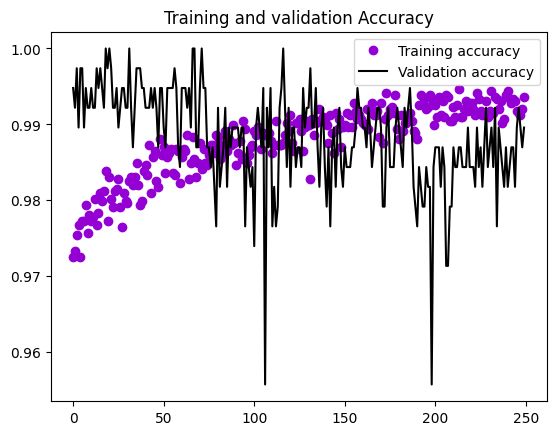

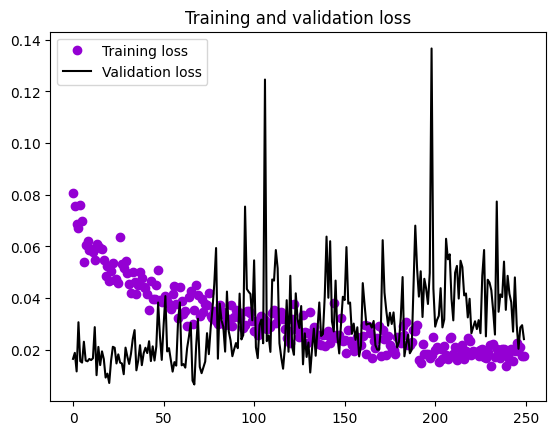

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs_x = range(len(loss))


# plt.plot(epochs_x, mse, 'go', label='Training MSE')
plt.plot(epochs_x, acc, 'o', color ='darkviolet', label='Training accuracy')
plt.plot(epochs_x, val_acc, 'k', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()
# plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, loss, 'o', color ='darkviolet', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
epochs_x

range(0, 250)

#Download the model


In [ ]:
os.makedirs('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model', exist_ok=True)
model.save('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func_224/1_4_2e-5_250_Unreeze.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
